# Explaining Image Captioning (Image to Text) using Open Source Image Captioning Model and Partition Explainer

This notebook demonstrates how to use SHAP for explaining output of image captioning models i.e. given an image, model outputs a caption for the image. 

Here, we are using a pre-trained open source model from https://github.com/ruotianluo/ImageCaptioning.pytorch to get image captions. All pre-trained models are available at https://github.com/ruotianluo/ImageCaptioning.pytorch/blob/master/MODEL_ZOO.md. Particularly, this notebook uses the model trained with ResNet101 features linked under "FC+new_self_critical" model & metrics https://drive.google.com/open?id=1OsB_jLDorJnzKz6xsOfk1n493P3hwOP0.

### Limitations 

1. To explain image captions, we are segmenting images along axes (i.e. super pixels/partitions of halves, quarters, eights...); An alternate approach/future improvement could be to semantically segment images instead of axis-aligned partitioning and produce SHAP explanations using segments, instead of super pixels. https://github.com/slundberg/shap/issues/1738 

2. We are using transformer language model (ex. distilbart) to do alignment scoring between given image and masked image captions, assuming an external model is a good surrogate for the original captioning model's language head. By using the captioning model's own language head, we could eliminate this assumption and remove the dependency. (ex. refer to text2text notebook examples). For more details, refer to the "Load language model and tokenizer" section below. https://github.com/slundberg/shap/issues/1739 

3. The more evaluations used to generate explanations, longer it takes for SHAP to run. But, increasing the number of evaluations increases the granularity of the explanations (300-500 evaluations often produce detailed maps, but fewer or more are also often reasonable). Refer to "Create an explainer object using wrapped model and image masker" section below for more details.

### Setting up open source model

##### Note: It is important to follow set up instructions exactly as given below to ensure notebook runs.

1. Clone https://github.com/ruotianluo/ImageCaptioning.pytorch repo. In a terminal type: 'git clone https://github.com/ruotianluo/ImageCaptioning.pytorch'.

2. Change below PREFIX variable to have absolute path of your ImageCaptioning.pytorch folder. This is an important step to ensure all file paths are accessed correctly.

3. Download the following files and place them in the folders as given:
    1. "model-best.pth": download from here https://drive.google.com/drive/folders/1OsB_jLDorJnzKz6xsOfk1n493P3hwOP0  and place in the cloned directory.
    2. "infos_fc_nsc-best.pkl": download from here https://drive.google.com/drive/folders/1OsB_jLDorJnzKz6xsOfk1n493P3hwOP0 and place in the cloned directory
    3. "resnet101": download from here https://drive.google.com/drive/folders/0B7fNdx_jAqhtbVYzOURMdDNHSGM and place in the cloned directory under 'data/imagenet_weights' folder. Create 'imagenet_weights' folder under 'data' directory if it doesn't exist. 

4. In a terminal, navigate to the cloned folder and type "python -m pip install -e ." or in a cell in jupyter notebook "!python -m pip install -e ." to install the module. 

5. Restart and clear kernel output to run this notebook. 

6. *Optional*: After running cells below in "Load sample data" section which loads sample data and creates a './test_images/' folder, try "python tools/eval.py --model model-best.pth --infos_path infos_fc_nsc-best.pkl --image_folder test_images --num_images 10" command in a terminal to verify that the installation was succesful. If it fails, please install any missing packages. ex. if 'lmdbdict' package is missing, try installing using "pip install git+https://github.com/ruotianluo/lmdbdict.git". If captions are shown in terminal output, then the installation was successful. 

    ##### Note: If these commands are being tested in a jupyter notebook, append ! in front of the commands. ex. "!python -m pip install -e ."

### Load sample data 

In [1]:
import os
import shap
from shap.utils.image import *

In [3]:
#change PREFIX to have absolute path of cloned directory of ImageCaptioning.pytorch 
PREFIX = r"<place full path to the cloned directory of ImageCaptioning.pytorch>/ImageCaptioning.pytorch"
os.chdir(PREFIX)

# directory of images to be explained 
DIR = './test_images/' 
# creates or empties directory if it already exists
make_dir(DIR)
add_sample_images(DIR)

# directory for saving masked images
DIR_MASKED = './masked_images/'

In [4]:
import captioning
import captioning.models as models
import captioning.utils.eval_utils as eval_utils
import captioning.utils.misc as utils
import captioning.modules.losses as losses
from captioning.data.dataloader import *
from captioning.data.dataloaderraw import *
import gc
import sys
import torch
from transformers import AutoTokenizer,AutoModelForSeq2SeqLM

# to suppress verbose output from open source model
from contextlib import contextmanager
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        old_stderr = sys.stderr
        sys.stderr = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

cider or coco-caption missing


### Getting captions using open source model

In [5]:
class ImageCaptioningPyTorchModel:
    """
    Wrapper class to get image captions using Resnet model from setup above. 
    Note: This class is being used instead of tools/eval.py to get predictions (captions). 
    To get more context for this class, please refer to tools/eval.py file. 
    """
    
    def __init__(self, model_path, infos_path, cnn_model = "resnet101", device = "cuda"):
        """
        Initializing the class by loading torch model and vocabulary at path given and using Resnet weights stored in data/imagenet_weights. 
        This is done to speeden the process of getting image captions and avoid loading the model every time captions are needed. 
        Parameters
        ----------
        model_path  : pre-trained model path
        infos_path  : pre-trained infos (vocab) path
        cnn_model   : resnet model weights to use; options: "resnet101" (default), "resnet152"
        device      : "cpu" or "cuda" (default)
        """

        # load infos
        with open(infos_path, 'rb') as f:
            infos = utils.pickle_load(f)
        opt = infos['opt']
        
        # setup the model
        opt.model = model_path
        opt.cnn_model = cnn_model
        opt.device = device
        opt.vocab = infos['vocab'] # ix -> word mapping
        model = models.setup(opt)
        del infos
        del opt.vocab
        model.load_state_dict(torch.load(opt.model, map_location='cpu'))
        model.to(opt.device)
        model.eval()
        crit = losses.LanguageModelCriterion()
        
        # setup class variables for call function
        self.opt = opt
        self.model = model
        self.crit = crit
        self.infos_path = infos_path

        # free memory
        torch.cuda.empty_cache()
        gc.collect()
        

    def __call__(self, image_folder, batch_size):
        """
        Function to get captions for images placed in image_folder. 
        Parameters
        ----------
        image_folder: folder of images for which captions are needed
        batch_size  : number of images to be evaluated at once
        Output
        -------
        captions    : list of captions for images in image_folder (will return a string if there is only one image in folder)
        """

        # setting eval options
        opt = self.opt
        opt.batch_size = batch_size
        opt.image_folder = image_folder
        opt.coco_json = ""
        opt.dataset = opt.input_json
        opt.verbose_loss = 0
        opt.verbose = False
        opt.dump_path = 0
        opt.dump_images = 0
        opt.num_images = -1
        opt.language_eval = 0
        
        # loading vocab
        with open(self.infos_path, 'rb') as f:
            infos = utils.pickle_load(f)
        opt.vocab = infos['vocab']
            
        # creating Data Loader instance to load images
        if len(opt.image_folder) == 0:
            loader = DataLoader(opt)
        else:
            loader = DataLoaderRaw({'folder_path': opt.image_folder, 
                                    'coco_json': opt.coco_json,
                                    'batch_size': opt.batch_size,
                                    'cnn_model': opt.cnn_model})
            
        # when evaluating using provided pretrained model, vocab may be different from what is in cocotalk.json. 
        # hence, setting vocab from infos file.
        loader.dataset.ix_to_word = opt.vocab
        del infos
        del opt.vocab
        
        # getting caption predictions 
        _, split_predictions, _ = eval_utils.eval_split(self.model, self.crit, loader, vars(opt))
        captions = []
        for line in split_predictions:
            captions.append(line['caption'])
        
        # free memory
        del loader
        torch.cuda.empty_cache()
        gc.collect()
            
        return captions if len(captions) > 1 else captions[0]

In [6]:
# create instance of ImageCaptioningPyTorchModel
osmodel = ImageCaptioningPyTorchModel(model_path = "model-best.pth",
                        infos_path = "infos_fc_nsc-best.pkl", 
                        cnn_model = "resnet101", 
                        device = "cpu")

# create function to get caption using model created above
def get_caption(model, image_folder, batch_size):
    return model(image_folder, batch_size)

### Load data

'./test_images/' is the folder of images that will be explained. './test_images/' directory has been created for you and sample images needed to replicate examples shown in the notebook are already placed in the directory. 

### Note: **Replace or add images that you would like to be explained(tested) in the './test_images/' folder.**

In [7]:
# checks if test images folder exists and if it has any files
if not is_empty(DIR):

    X = []
    print("Loading data...")
    files = [f for f in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, f))]
    for file in files:
        path_to_image = os.path.join(DIR, file)
        print("Loading image:", file)
        X.append(load_image(path_to_image))
    with suppress_stdout():
        captions = get_caption(osmodel, "test_images", 5)
    if len(X) > 1:
       print("\nCaptions are...", *captions, sep = "\n")
    else:
        print("\nCaption is...", captions)
    print("\nNumber of images in test dataset:", len(X))

Loading data...
Loading image: 1.jpg
Loading image: 2.jpg
Loading image: 3.jpg
Loading image: 4.jpg

Captions are...
a woman sitting on a bench
a bird sitting on top of a tree branch
a group of horses standing next to a fence
a group of people playing with a soccer ball

Number of images in test dataset: 4


### Load language model and tokenizer

Transformer Language Model 'distilbart' and tokenizer are being used here to tokenize the image caption. This makes the image to text scenario similar to a multi-class problem. 'distilbart' is used to do alignment scoring between the original image caption and masked image captions being generated i.e. how does the probability of getting the original image caption change when the context of a masked image caption is given? (a.k.a. we are teacher forcing 'distilbart' to always produce the original image caption for the masked images and getting change in logits for each tokenized word in the caption as part of the process).

**Note**: We are using 'distilbart' here because during experimentation process we found it to give the most meaningful explanations for images. We have compared with other language models such as 'openaigpt' and 'distilgpt2'. Please feel free to explore with other language models of your choice and compare the results. 

In [8]:
# load transformer language model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-xsum-12-6")
model =  AutoModelForSeq2SeqLM.from_pretrained("sshleifer/distilbart-xsum-12-6").cuda()

### Create an explainer object using wrapped model and image masker

Various options for explainer object to experiment with:

1. **mask_value**      : Image masker uses an inpainting technqiue by default for masking (i.e. mask_value = "inpaint_ns"). There are alternate masking options available for blurring/inpainting  such as "inpaint_telea" and "blur(kernel_xsize, kernel_xsize)". Note: Different explanations can be generated by different masking options.

2. **max_evals**       : Number of evaluations done of the underlying model to get SHAP values. Recommended number of evaluations is 300-500 to get explanations with meaningful granularity of super pixels. More the number of evaluations, more the granularity but also increases run-time. Default is set to 300 evals. 

3. **batch_size**      : Number of masked images to be evaluated at once. Default size is set to 50. 

4. **fixed_context**   : Masking technqiue used to build partition tree with options of '0', '1' or 'None'. 'fixed_context = None' is the best option to generate meaningful results but it is relatively slower than fixed_context = 0 or 1 because it generates a full partition tree. Default option is set to 'None'. 

In [9]:
# setting values for logging/tracking variables
make_dir(DIR_MASKED)
image_counter = 0 
mask_counter = 0 


# define function f which takes input (masked image) and returns caption for it 
def f(x): 
    global mask_counter
    
    # emptying masked images directory 
    make_dir(DIR_MASKED)

    # saving masked array of RGB values as an image in masked_images directory
    path_to_image = os.path.join(DIR_MASKED, "{0}_{1}.png".format(image_counter, mask_counter))
    save_image(x, path_to_image) 
    
    # getting caption of masked image 
    with suppress_stdout():
        caption = get_caption(osmodel, "masked_images", 5) 
    mask_counter += 1 
    
    return caption

# function to take a list of images and parameters such as masking option, max evals etc. and return shap_values_objects
def run_masker(X, mask_value = "inpaint_ns", max_evals = 300, batch_size = 50, fixed_context = None):
    """
    Function to take a list of images and parameters such max evals etc. and return shap explanations (shap_values) for test images(X).
    Paramaters
    ----------
    X               : list of images which need to be explained
    mask_value      : various masking options for blurring/inpainting such as "inpaint_ns", "inpaint_telea" and "blur(pixel_size, pixel_size)"
    max_evals       : number of evaluations done of the underlying model to get SHAP values 
    batch_size      : number of masked images to be evaluated at once 
    fixed_context   : masking technqiue used to build partition tree with options of '0', '1' or 'None'
    Output
    ------
    shap_values_list: list of shap_values objects generated for the images
    """
    global image_counter
    global mask_counter
    shap_values_list = []

    for index in range(len(X)): 

        # define a masker that is used to mask out partitions of the input image based on mask_value option
        masker = shap.maskers.Image(mask_value, X[index].shape)

        # wrap model with TeacherForcingLogits class
        wrapped_model = shap.models.TeacherForcingLogits(f, similarity_model=model, similarity_tokenizer=tokenizer)

        # build a partition explainer with wrapped_model and image masker
        explainer = shap.Explainer(wrapped_model, masker) 

        # compute SHAP values - here we use max_evals no. of evaluations of the underlying model to estimate SHAP values
        shap_values = explainer(np.array(X[index:index+1]), max_evals = max_evals, batch_size = batch_size, fixed_context = fixed_context)
        shap_values_list.append(shap_values)

        # output plot
        shap_values.output_names[0] = [word.replace('Ġ', '') for word in shap_values.output_names[0]]
        shap.image_plot(shap_values)

        # setting values for next iterations
        mask_counter = 0
        image_counter += 1
    
    return shap_values_list

### SHAP explanation for test images

Partition explainer: 2it [36:16, 1088.29s/it]             


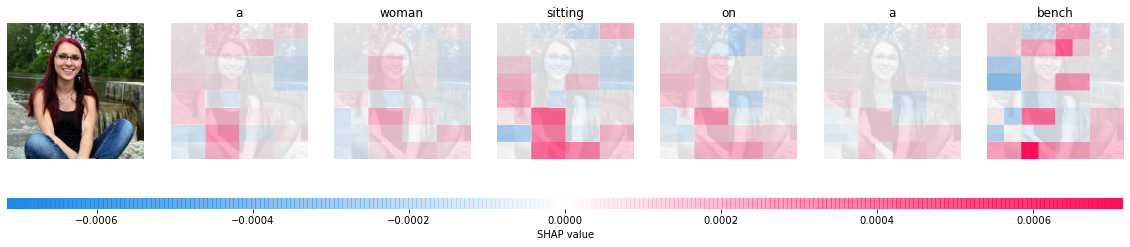

Partition explainer: 2it [05:47, 173.60s/it]              


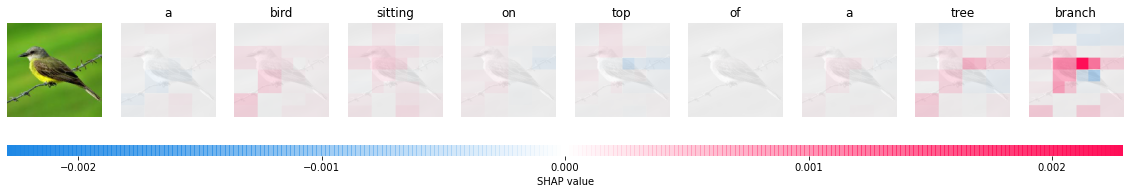

Partition explainer: 2it [05:44, 172.26s/it]              


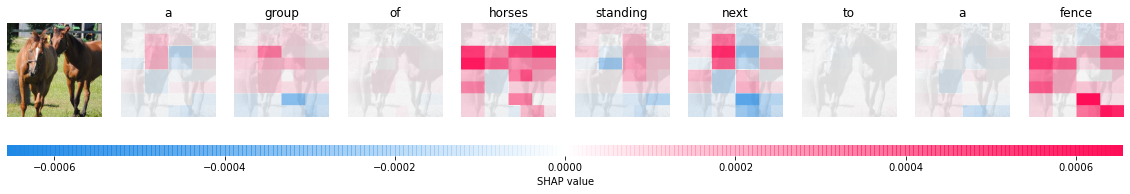

Partition explainer: 2it [05:42, 171.46s/it]              


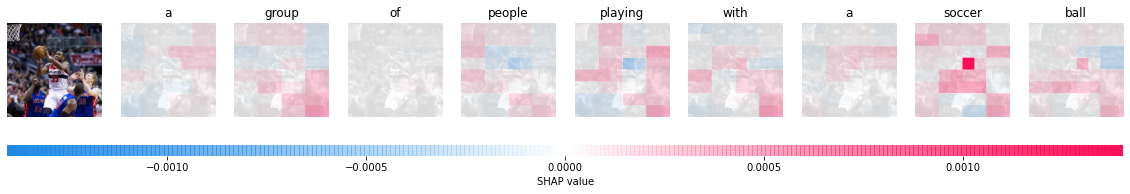

In [25]:
# SHAP explanation using masking option "blur(pixel_size, pixel_size)" for blurring
shap_values = run_masker(X, mask_value="blur(56,56)")

Partition explainer: 2it [05:38, 169.49s/it]              


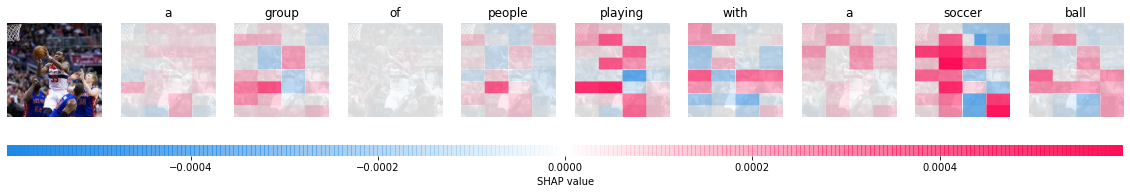

In [26]:
# SHAP explanation using masking option "inpaint_telea" for inpainting
shap_values = run_masker(X[3:4], mask_value= "inpaint_telea")